# Partial differencial equations

In [2]:
#librairies
import numpy as np # Créer des vecteurs/matrices et autres opérations
import scipy.linalg as la # Faire de l'algèbre linéaire
from scipy.sparse import diags # Créer des matrices spécifiques
import matplotlib.pyplot as plt # Pour faire des graphiques
import matplotlib.animation as animation # Pour faire des animations
from IPython.display import HTML # Pour afficher l'animation

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Exo 1

Solve wave equation,

$\displaystyle \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0,$

subject to initial condition,

$\displaystyle u(x, 0) = \sin{(2 \pi x)}$,

and periodic boundary condition, i. e.

$\displaystyle u(x, t) = u(x + L, t),\,\, \frac{\partial u}{\partial x}(x, t) = \frac{\partial u}{\partial x}(x + L, t)$ etc.

Utilize second-order Adams-Bashforth method to time-advance your solution, and second-order central finite differences to approximate spatial derivative.

Assume that $-1 \le x \le 1$, $0 \le t \le 1.0$ and $c = 1$. Make sure you've chosen $dt$ and $dx$ appropriately, so that the scheme does not blow up.

*Adams-Bashforth method is given by:*

$\displaystyle u^{n + 2} = u^{n + 1} + \Delta t \left( \frac32 f^{n + 1} - \frac12 f^{n}\right)$,

*where $f$ is the right-hand side of the initial value problem.*

Dans cette exercice on veut résoudre un PDE en utilisant la méthode d'Adams-Bashforth. Pour implémenter cette méthode on va utiliser les "time integrations schemes" et les différences finies dont les méthodes ont été vue dans les notebooks du même noms

Notre problème peut se réécrire comme suit 
\begin{equation}
    \frac{\partial u}{\partial t} = -c \frac{\partial u}{\partial x}
\end{equation}

On va donc implémenté le membre de droite (RHS) et résoudre le membre de gauche à l'aide de Adam-Bashforth, de sorte que dans cette méthode, on a $f=RHS$

In [5]:
# On initialise notre problème
c = 1
ti, tf = 0, 1
dt = 1e-3
nt = int((tf - ti) / dt)
nx = 100
x = np.linspace(-1, 1, nx) # On crée l'intervale [-1,1] qui comporte nx point
dx = x[1] - x[0]

On crée la matrice des différences finies centrée pour $\frac{\partial u}{\partial x}$.

In [9]:
# On implémente la matrice des différences finies
def d1(nx, dx):
    coeffs = [[-1 / 2], [1 / 2]]
    offsets = [-1, 1]
    
    mat = diags(coeffs, offsets, shape=(nx, nx)).A / dx
    
    return mat

'''Les info sur comment construire cette matrice sont donnée dans le notebook "finite differences". Dans ce cas ci on ne remplace pas les bords gauche et droit car on a des conditions périodique'''

'Les info sur comment construire cette matrice sont donnée dans le notebook "finite differences". Dans ce cas ci on ne remplace pas les bords gauche et droit car on a des conditions périodique'

On utilise une fonction python pour définir le membre de droite (RHS) qui est $-c \frac{\partial u}{\partial x}$. En utilisant les différences fini on peut réécrire le membre de droite comme 
\begin{equation}
    RHS = -c (d1*u)
\end{equation}
où $u$ est la solution et $d1$ est la matrice des différences finies.

In [12]:
# On définie le membre de droite

def rhs_periodic(u, dx, c):
    mat = d1(u.size, dx)
    
    # On implémente les conditions périodique
    mat[0] = np.zeros(nx)
    mat[-1] = np.zeros(nx)
    mat[0, 1] = 1 / 2 / dx
    mat[0, -2] = -1 / 2 / dx
    mat[-1, 1] = 1 / 2 / dx
    mat[-1, -2] = -1 / 2 / dx
    
    return -c * mat @ u

'''On utilise les conditions périodique pour avoir des info concernant les bords gauche et droit qui ne nous sont pas accecible avec les différences finies
centré. La fonction python nous retourne "-c* mat @ u" qui est bien notre RHS'''

'On utilise les conditions périodique pour avoir des info concernant les bords gauche et droit qui ne nous sont pas accecible avec les différences finies\ncentré. La fonction python nous retourne "-c* mat @ u" qui est bien notre RHS'

On implémente, à l'aide d'une fonction python, la méthode d'Adams_Bashforth.

In [13]:
def adams_bash(u, f, dt, *args):
    return u[0] + dt * 0.5 * (3 * f(u[0], *args) - f(u[1], *args))

'''La fonction prend 4 arguments : u, f, dt et *args. u est une liste dans lequels on va stocker nos solutions pour chaque instant du temps et chaque position
dans l'espace (c'est donc une matrice de taille nt x nx). f est notre membre de droite, dans notre cas RHS. dt et la taille de chaque pas de temps que l'on éfectue 
à chaque itération. *args est une méthode qui nous permet de prendre en compte les paramètre de f. car ce derniers est RHS qui est aussi une fonction python avec ces propres arguments et il faut que notre fonction
les prennent en compte, c'est ce que fait *args.'''

"La fonction prend 4 arguments : u, f, dt et *args. u est une liste dans lequels on va stocker nos solutions pour chaque instant du temps et chaque position\ndans l'espace (c'est donc une matrice de taille nt x nx). f est notre membre de droite, dans notre cas RHS. dt et la taille de chaque pas de temps que l'on éfectue \nà chaque itération. *args est une méthode qui nous permet de prendre en compte les paramètre de f. car ce derniers est RHS qui est aussi une fonction python avec ces propres arguments et il faut que notre fonction\nles prennent en compte, c'est ce que fait *args."

La méthode d'Adams_Bashforth ne nous permet pas de réaliser la première itération (car on a besoin de u[n-1]) donc pour ce faires on utilise Euler Forward.

In [14]:
# On résoud !

u = np.empty((nt + 1, nx)) # On crée la matrice qui stocke les solutions
u[0] = np.sin(2 * np.pi * x) # On ajoute la condition initiale

u[1] = u[0] + dt * rhs_periodic(u[0], dx, c) # On effectue Euler forward pour la première itération

for n in range(1, nt): #on itère pour chacque instant du temps avec la méthode d'Adams_Bashforth implémenté plus haut
    u[n + 1] = adams_bash([u[n], u[n - 1]], rhs_periodic, dt, dx, c)

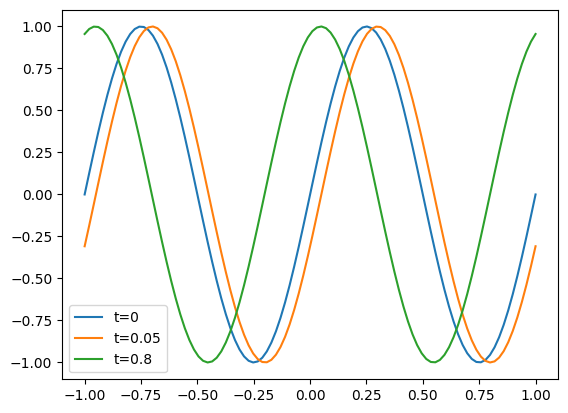

In [15]:
# On plot notre solution avec matplotlib

fig, ax = plt.subplots(1, 1)

ax.plot(x, u[0], label="t=0")
ax.plot(x, u[int(0.05 / dt)], label="t=0.05")
ax.plot(x, u[int(0.8 / dt)], label="t=0.8")

ax.legend()

On va maintenant créer un animation qui nous montrera comment notre solution varie au cours du temps.

L'animation est faite à l'aide de *mathplotlib.animation*, de ce fait elle demande une initialisation similaire à ce que l'on a quand on veut plot un graph avec matplotlib. On peut voir une animation comme plein de plot matplotlib qui sont crée et affiché l'un à la suite de l'autre.

In [17]:
fig, ax = plt.subplots(1, 1) # On crée note espace et nos ax pour les plot

line, = ax.plot([], [])

ax.set_xlim(x[0], x[-1]) # On setup les limites des axes
ax.set_ylim(-1.1, 1.1)

plt.close() # On utilise cette fonction pour pas que matplolib affiche un graph vide car pour l'instant on ne lui à donné aucune données

def animate(frame, dt, x, u): 
    line.set_data(x, u[frame])
    
    line.set_label(f"t={frame * dt: .2f}")
    
    ax.legend(loc="upper right")
    
    return line,

'''On crée une fontion "animate" qui va créer des frames qui sont simplement le plot de notre fonction à un instant donnée. la fonction "line.set_data(x,u[frame])" 
renvoie les coordonné de u pour chaque possition à l'instant t qui correspond à la frame en question. la fonction "line.set_label(f"t={frame * dt: .2f}"))" met en place le label
de la fonction pour chaque frame. la fonction "ax.legend(loc="upper right")" précise où la légende doit être affiché sur le graph.'''

'On crée une fontion "animate" qui va créer des frames qui sont simplement le plot de notre fonction à un instant donnée. la fonction "line.set_data(x,u[frame])" \nrenvoie les coordonné de u pour chaque possition à l\'instant t qui correspond à la frame en question. la fonction "line.set_label(f"t={frame * dt: .2f}"))" met en place le label\nde la fonction pour chaque frame. la fonction "ax.legend(loc="upper right")" précise où la légende doit être affiché sur le graph.'

In [18]:
frames = np.arange(0, nt + 10, 10) # On définie nos frames
fargs = dt, x, u # On stock les arguments dt, x et u dans une seul variable appelé fargs

In [19]:
anim = animation.FuncAnimation(
    fig,
    animate,
    interval=100, # delay between frames
    frames=frames,
    fargs=fargs,
)

'''On utilise la fonction "FuncAnimation" de matplotlib.animation pour produire l'animation que l'on a setup au dessus. Cette fonction prend comme argument 
la figure créé par matplotlib (fig), la fonction animate que l'on a créé juste au dessus, l'intervale de temps entre chaque frame (interval) qui permet de rendre
l'animation plus rapide ou plus lente, les frames en question (frames) et les différent arguments regroupé dans fargs (fargs).'''

'On utilise la fonction "FuncAnimation" de matplotlib.animation pour produire l\'animation que l\'on a setup au dessus. Cette fonction prend comme argument \nla figure créé par matplotlib (fig), la fonction animate que l\'on a créé juste au dessus, l\'intervale de temps entre chaque frame (interval) qui permet de rendre\nl\'animation plus rapide ou plus lente, les frames en question (frames) et les différent arguments regroupé dans fargs (fargs).'

In [20]:
HTML(anim.to_jshtml()) 

'''On utilise la fontion "HTML" de matplotlib.animation pour afficher l'animation que l'on vient de créer'''

'On utilise la fontion "HTML" de matplotlib.animation pour afficher l\'animation que l\'on vient de créer'